# Libraries

In [15]:
! pip install holidays

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

# Data Loader

In [17]:
# Define the base path for the data
base_path = '../data/raw'

# Initialize an empty dictionary to store dataframes
data_dict = {}

# Loop through each subfolder in the base path
for city_folder in os.listdir(base_path):
    city_path = os.path.join(base_path, city_folder)
    if os.path.isdir(city_path):
        city_data = {}
        for file_name in os.listdir(city_path):
            file_path = os.path.join(city_path, file_name)
            if file_name.endswith('.csv'):
                df = pd.read_csv(file_path)
                # Check if 'Unnamed: 0' column exists and drop it if found
                if 'Unnamed: 0' in df.columns:
                    df = df.drop(columns=['Unnamed: 0'])
                file_key = os.path.splitext(file_name)[0]
                city_data[file_key] = df
        data_dict[city_folder] = city_data

# Now `data_dict` holds each city's data, and 'Unnamed: 0' columns are removed if present

## Feature Engineering - Date Columns

In [18]:
# Loop through each city and apply transformations
for city, city_data in data_dict.items():
    # Process weather data directly in city_data['weather']
    if 'weather' in city_data:
        city_data['weather']['time'] = pd.to_datetime(city_data['weather']['time'], errors='coerce')
        city_data['weather'].dropna(subset=['time'], inplace=True)
        
        # Extract day and hour for merging
        city_data['weather']['day'] = city_data['weather']['time'].dt.date
        city_data['weather']['hour'] = city_data['weather']['time'].dt.hour
    
    # Process energy data directly in city_data['energy']
    if 'energy' in city_data:
        city_data['energy']['date'] = pd.to_datetime(city_data['energy']['date'], errors='coerce')
        city_data['energy'].dropna(subset=['date'], inplace=True)
        
        # Create additional columns based on 'date'
        city_data['energy']['day'] = city_data['energy']['date'].dt.date
        city_data['energy']['month'] = city_data['energy']['date'].dt.month_name()
        city_data['energy']['day_name'] = city_data['energy']['date'].dt.day_name()
        city_data['energy']['hour'] = city_data['energy']['date'].dt.hour
        city_data['energy']['minute'] = city_data['energy']['date'].dt.minute
        
        # Define order of months and days
        month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                       'July', 'August', 'September', 'October', 'November', 'December']
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        # Convert 'month' and 'day_name' to ordered categorical types
        city_data['energy']['month'] = pd.Categorical(city_data['energy']['month'], categories=month_order, ordered=True)
        city_data['energy']['day_name'] = pd.Categorical(city_data['energy']['day_name'], categories=days_order, ordered=True)
        
        # Define time intervals for 'time_of_day'
        time_intervals = [0, 6, 12, 18, 24]
        time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
        city_data['energy']['time_of_day'] = pd.cut(city_data['energy']['hour'], bins=time_intervals, labels=time_labels, include_lowest=True, right=False)
        
        # Create 'is_weekend' column based on the day name
        city_data['energy']['is_weekend'] = pd.Categorical(city_data['energy']['day_name'].isin(['Saturday', 'Sunday']), categories=[False, True])

## Merge weather data - per city

In [19]:
# Loop through each city to merge the processed weather and energy DataFrames
for city, city_data in data_dict.items():
    # Merge if both DataFrames are available
    if 'weather' in city_data and 'energy' in city_data:
        # Perform the merge on 'day' and 'hour' with selected columns from weather
        city_data['df_merged'] = pd.merge(
            city_data['energy'],
            city_data['weather'][['day', 'hour', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']],
            on=['day', 'hour'],
            how='inner',
            suffixes=('_energy', '_weather')
        )

In [20]:
# Loop through each city and add the 'season' feature based on the 'month' column
for city, city_data in data_dict.items():
    if 'df_merged' in city_data:
        # Map the month to a season and assign it to a new 'season' column
        city_data['df_merged']['season'] = city_data['df_merged']['month'].apply(
            lambda month: 'Winter' if month in ['December', 'January', 'February'] else
                          'Spring' if month in ['March', 'April', 'May'] else
                          'Summer' if month in ['June', 'July', 'August'] else
                          'Fall'
        )

# Check for holidays

In [21]:
# Define the country for holidays 
country_holidays = holidays.US()  

# Loop through each city in data_dict and add the 'is_holiday' column to df_merged
for city, city_data in data_dict.items():
    if 'df_merged' in city_data:
        # Add 'is_holiday' column based on whether 'day' is a holiday
        city_data['df_merged']['is_holiday'] = city_data['df_merged']['day'].apply(lambda x: x in country_holidays)
        print(f"'is_holiday' column added for city '{city}'")

'is_holiday' column added for city 'austin'
'is_holiday' column added for city 'ny'


In [22]:
data_dict['ny']['df_merged'].columns

Index(['date', 'grid', 'bathroom', 'bedroom', 'car', 'diningroom',
       'livingroom', 'office', 'utilityroom', 'waterheater', 'aircomp',
       'kitchenArea', 'washer_dryer', 'other', 'day', 'month', 'day_name',
       'hour', 'minute', 'time_of_day', 'is_weekend', 'temp', 'dwpt', 'rhum',
       'wdir', 'wspd', 'pres', 'season', 'is_holiday'],
      dtype='object')

# Null Values

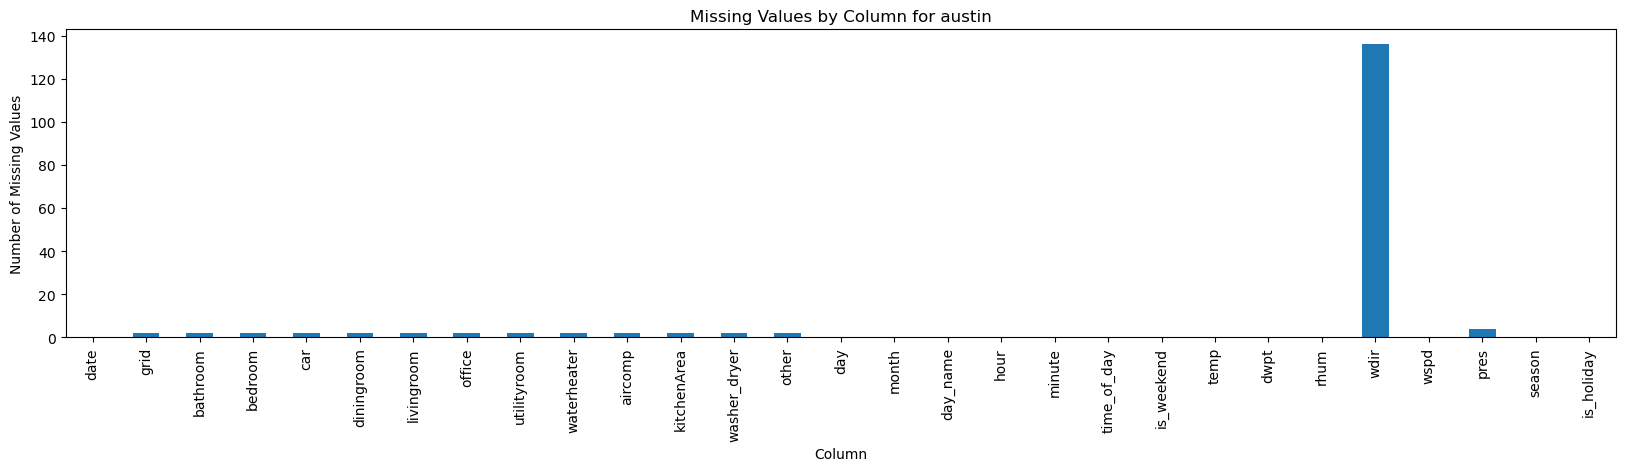

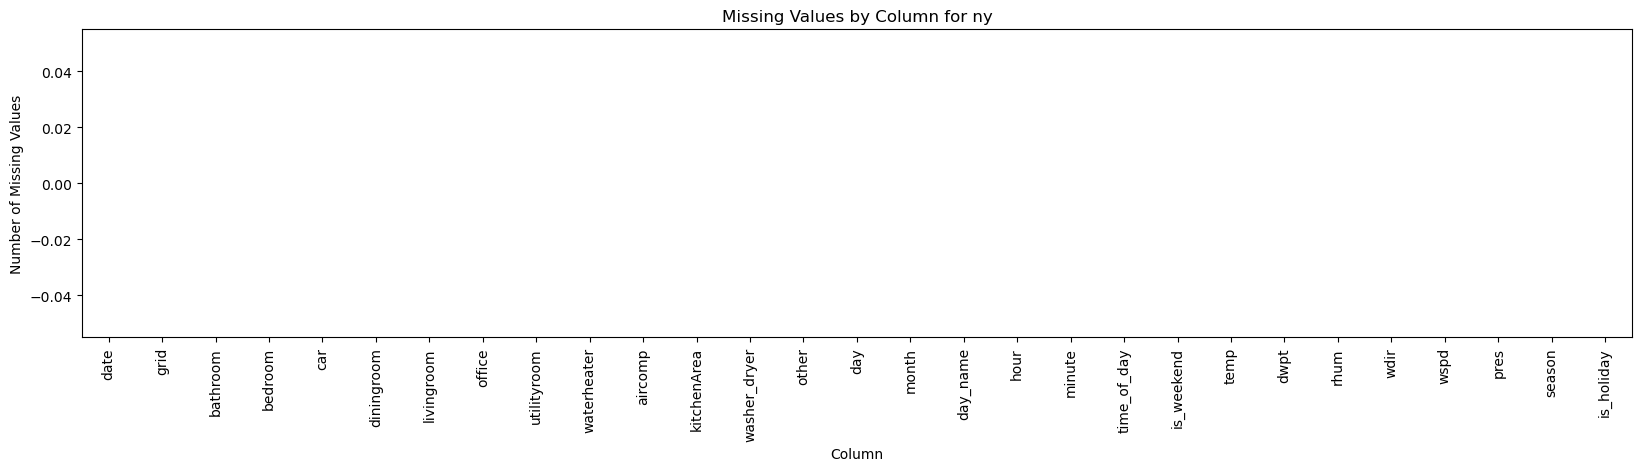

In [23]:
# Loop through each city and check for missing values in 'df_merged'
for city, city_data in data_dict.items():
    # Check if 'df_merged' exists in the city's data
    if 'df_merged' in city_data:
        df_merged = city_data['df_merged']
        
        # Create a bar plot of missing values by column
        plt.figure(figsize=(20, 4))
        df_merged.isnull().sum().plot(kind='bar')
        plt.title(f'Missing Values by Column for {city}')
        plt.xlabel('Column')
        plt.ylabel('Number of Missing Values')
        plt.show()

### Null handling

In [24]:
# Loop through each city and clean the 'df_merged' DataFrame
for city, city_data in data_dict.items():
    if 'df_merged' in city_data:
        df_merged = city_data['df_merged']
        
        # Calculate threshold for null values (20% of the data length)
        threshold = len(df_merged) * 0.2

        # Drop columns where the number of nulls exceeds the threshold
        df_cleaned = df_merged.dropna(thresh=threshold, axis=1)

        # Remove rows with any remaining null values
        df_cleaned = df_cleaned.dropna()

        # Calculate original and cleaned DataFrame sizes
        original_size = len(df_merged)
        cleaned_size = len(df_cleaned)

        # Calculate rows removed
        removed_rows = original_size - cleaned_size

        # Calculate percentage removed only if rows were removed
        if removed_rows > 0:
            percentage_removed = round((removed_rows / original_size) * 100, 2)
        else:
            percentage_removed = 0

        # Store the cleaned DataFrame back in the city data
        city_data['df_cleaned'] = df_cleaned

        # Print summary of cleaning for each city
        print(f"City: {city}")
        print("Number of rows removed:", removed_rows)
        print("Percentage of data removed:", percentage_removed, "%\n")

City: austin
Number of rows removed: 142
Percentage of data removed: 0.81 %

City: ny
Number of rows removed: 0
Percentage of data removed: 0 %



## Data Distribution

### Numerical

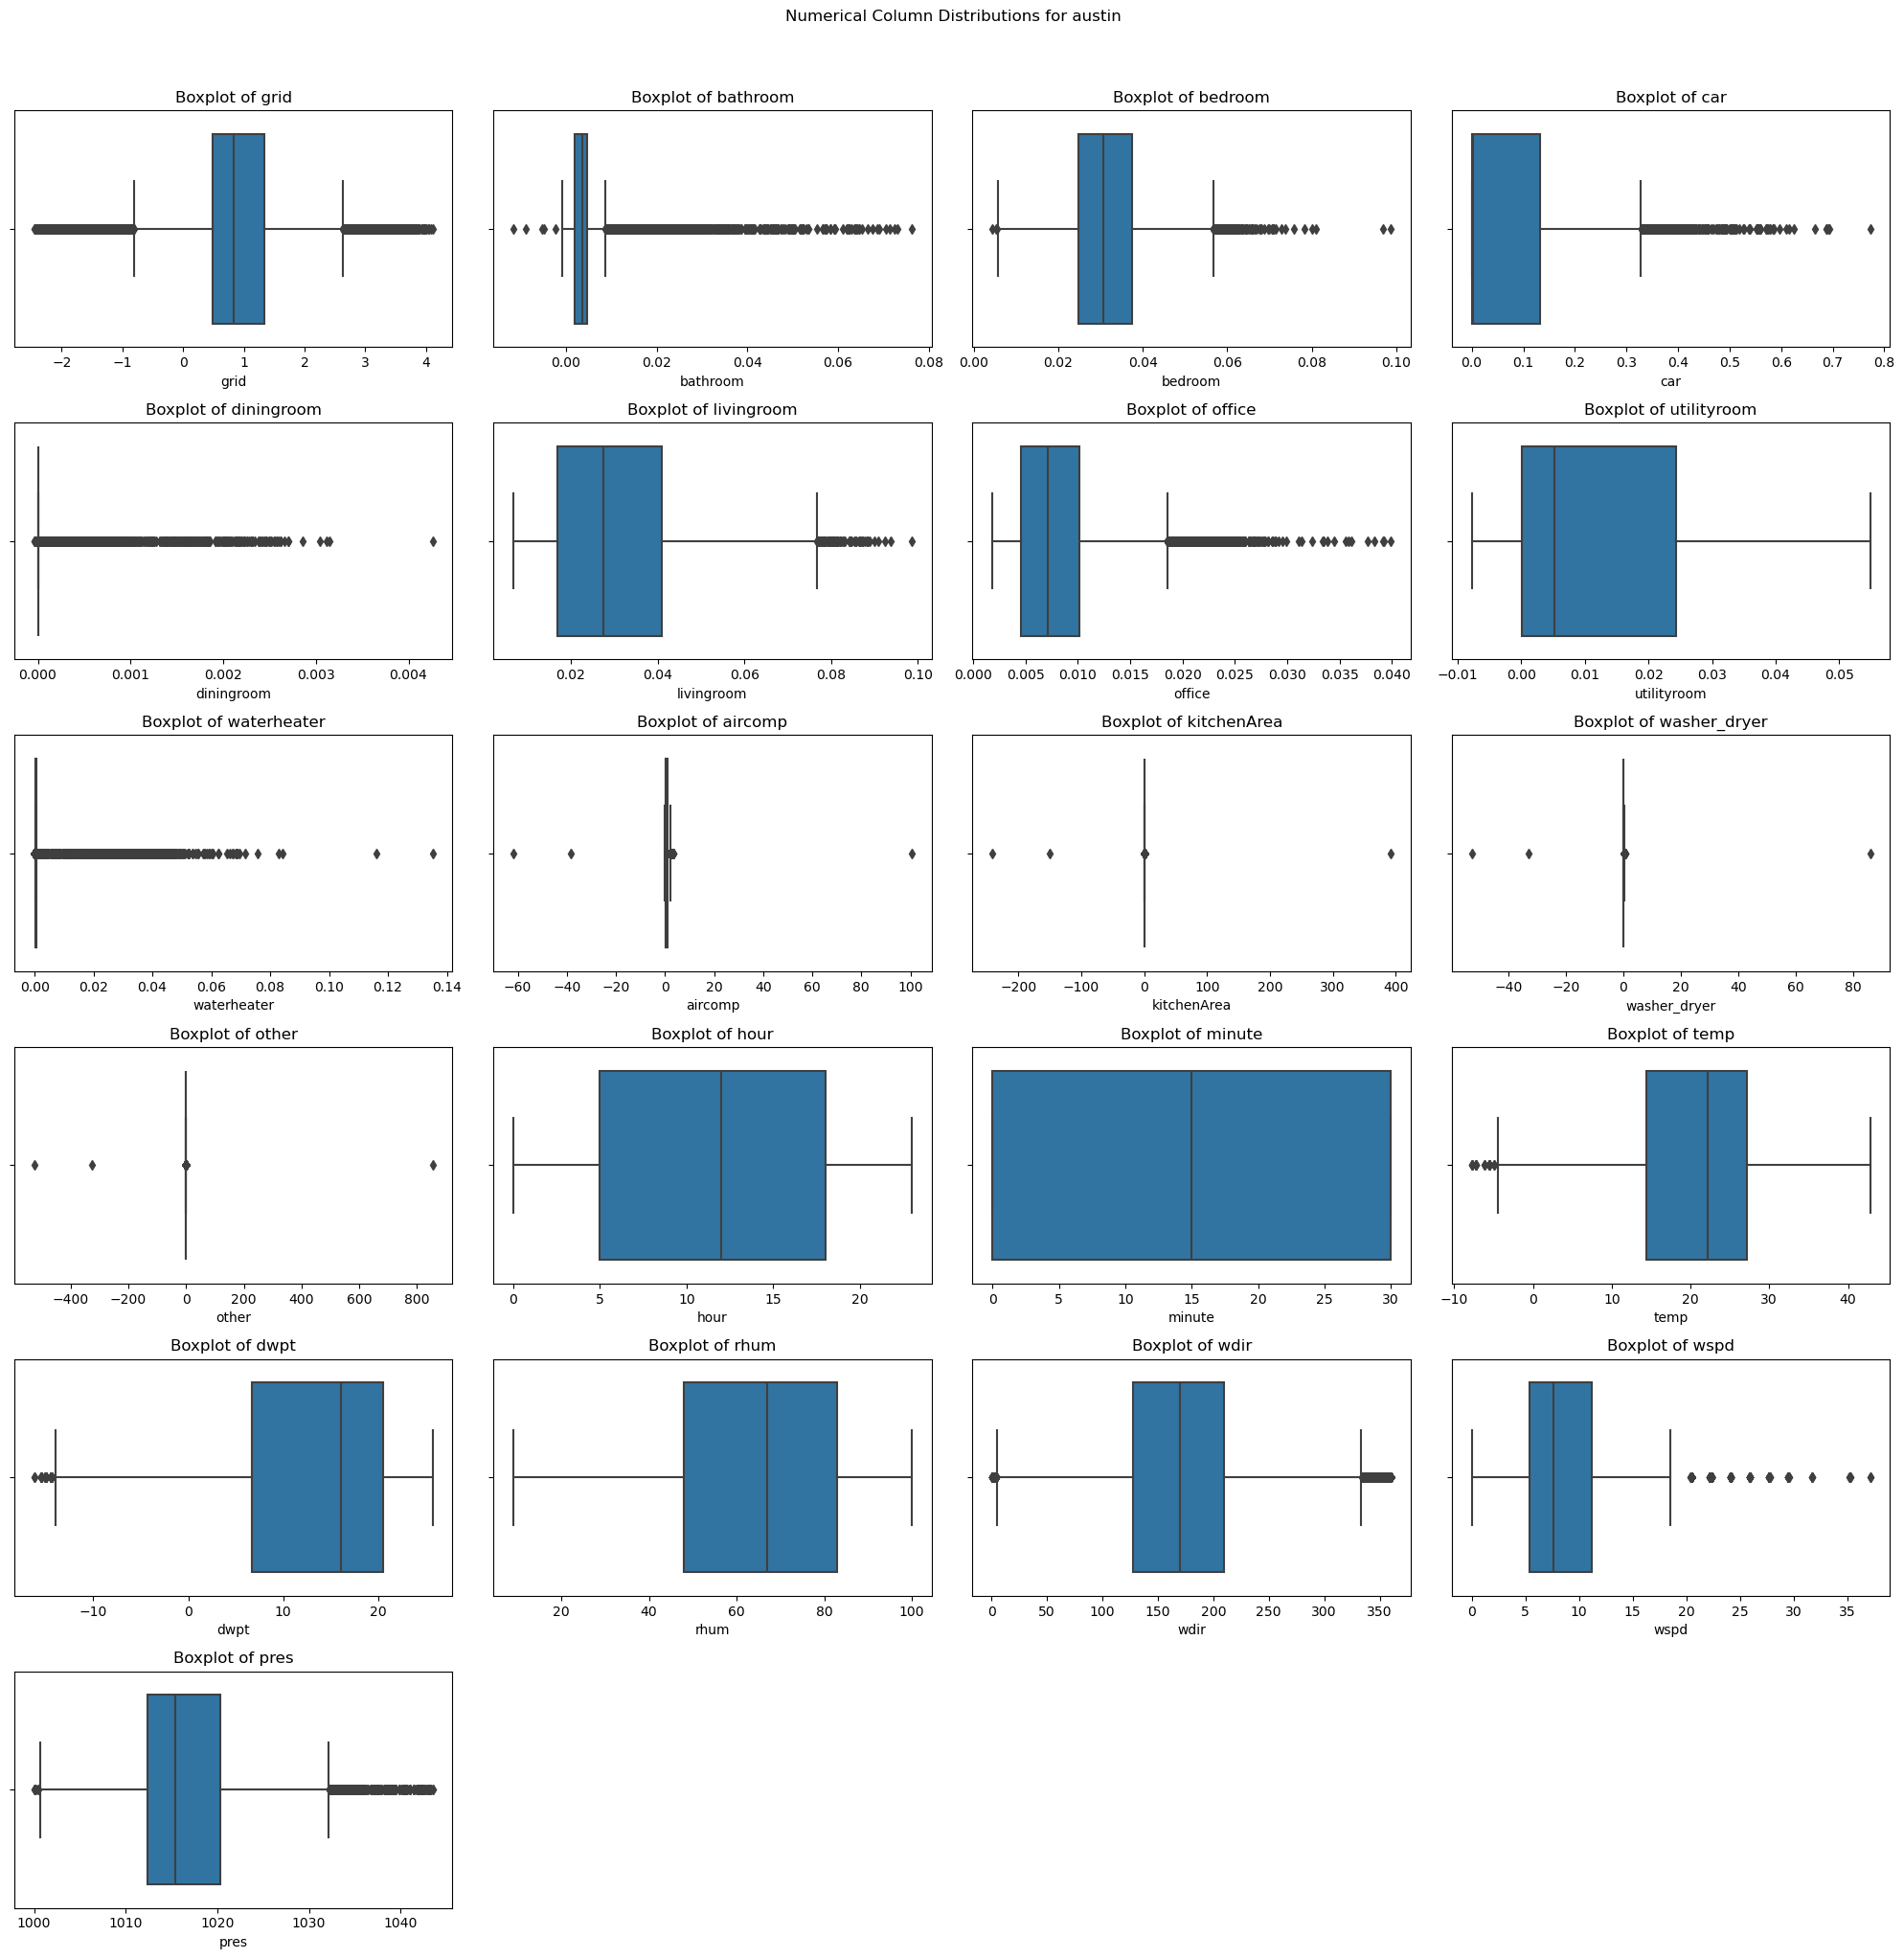

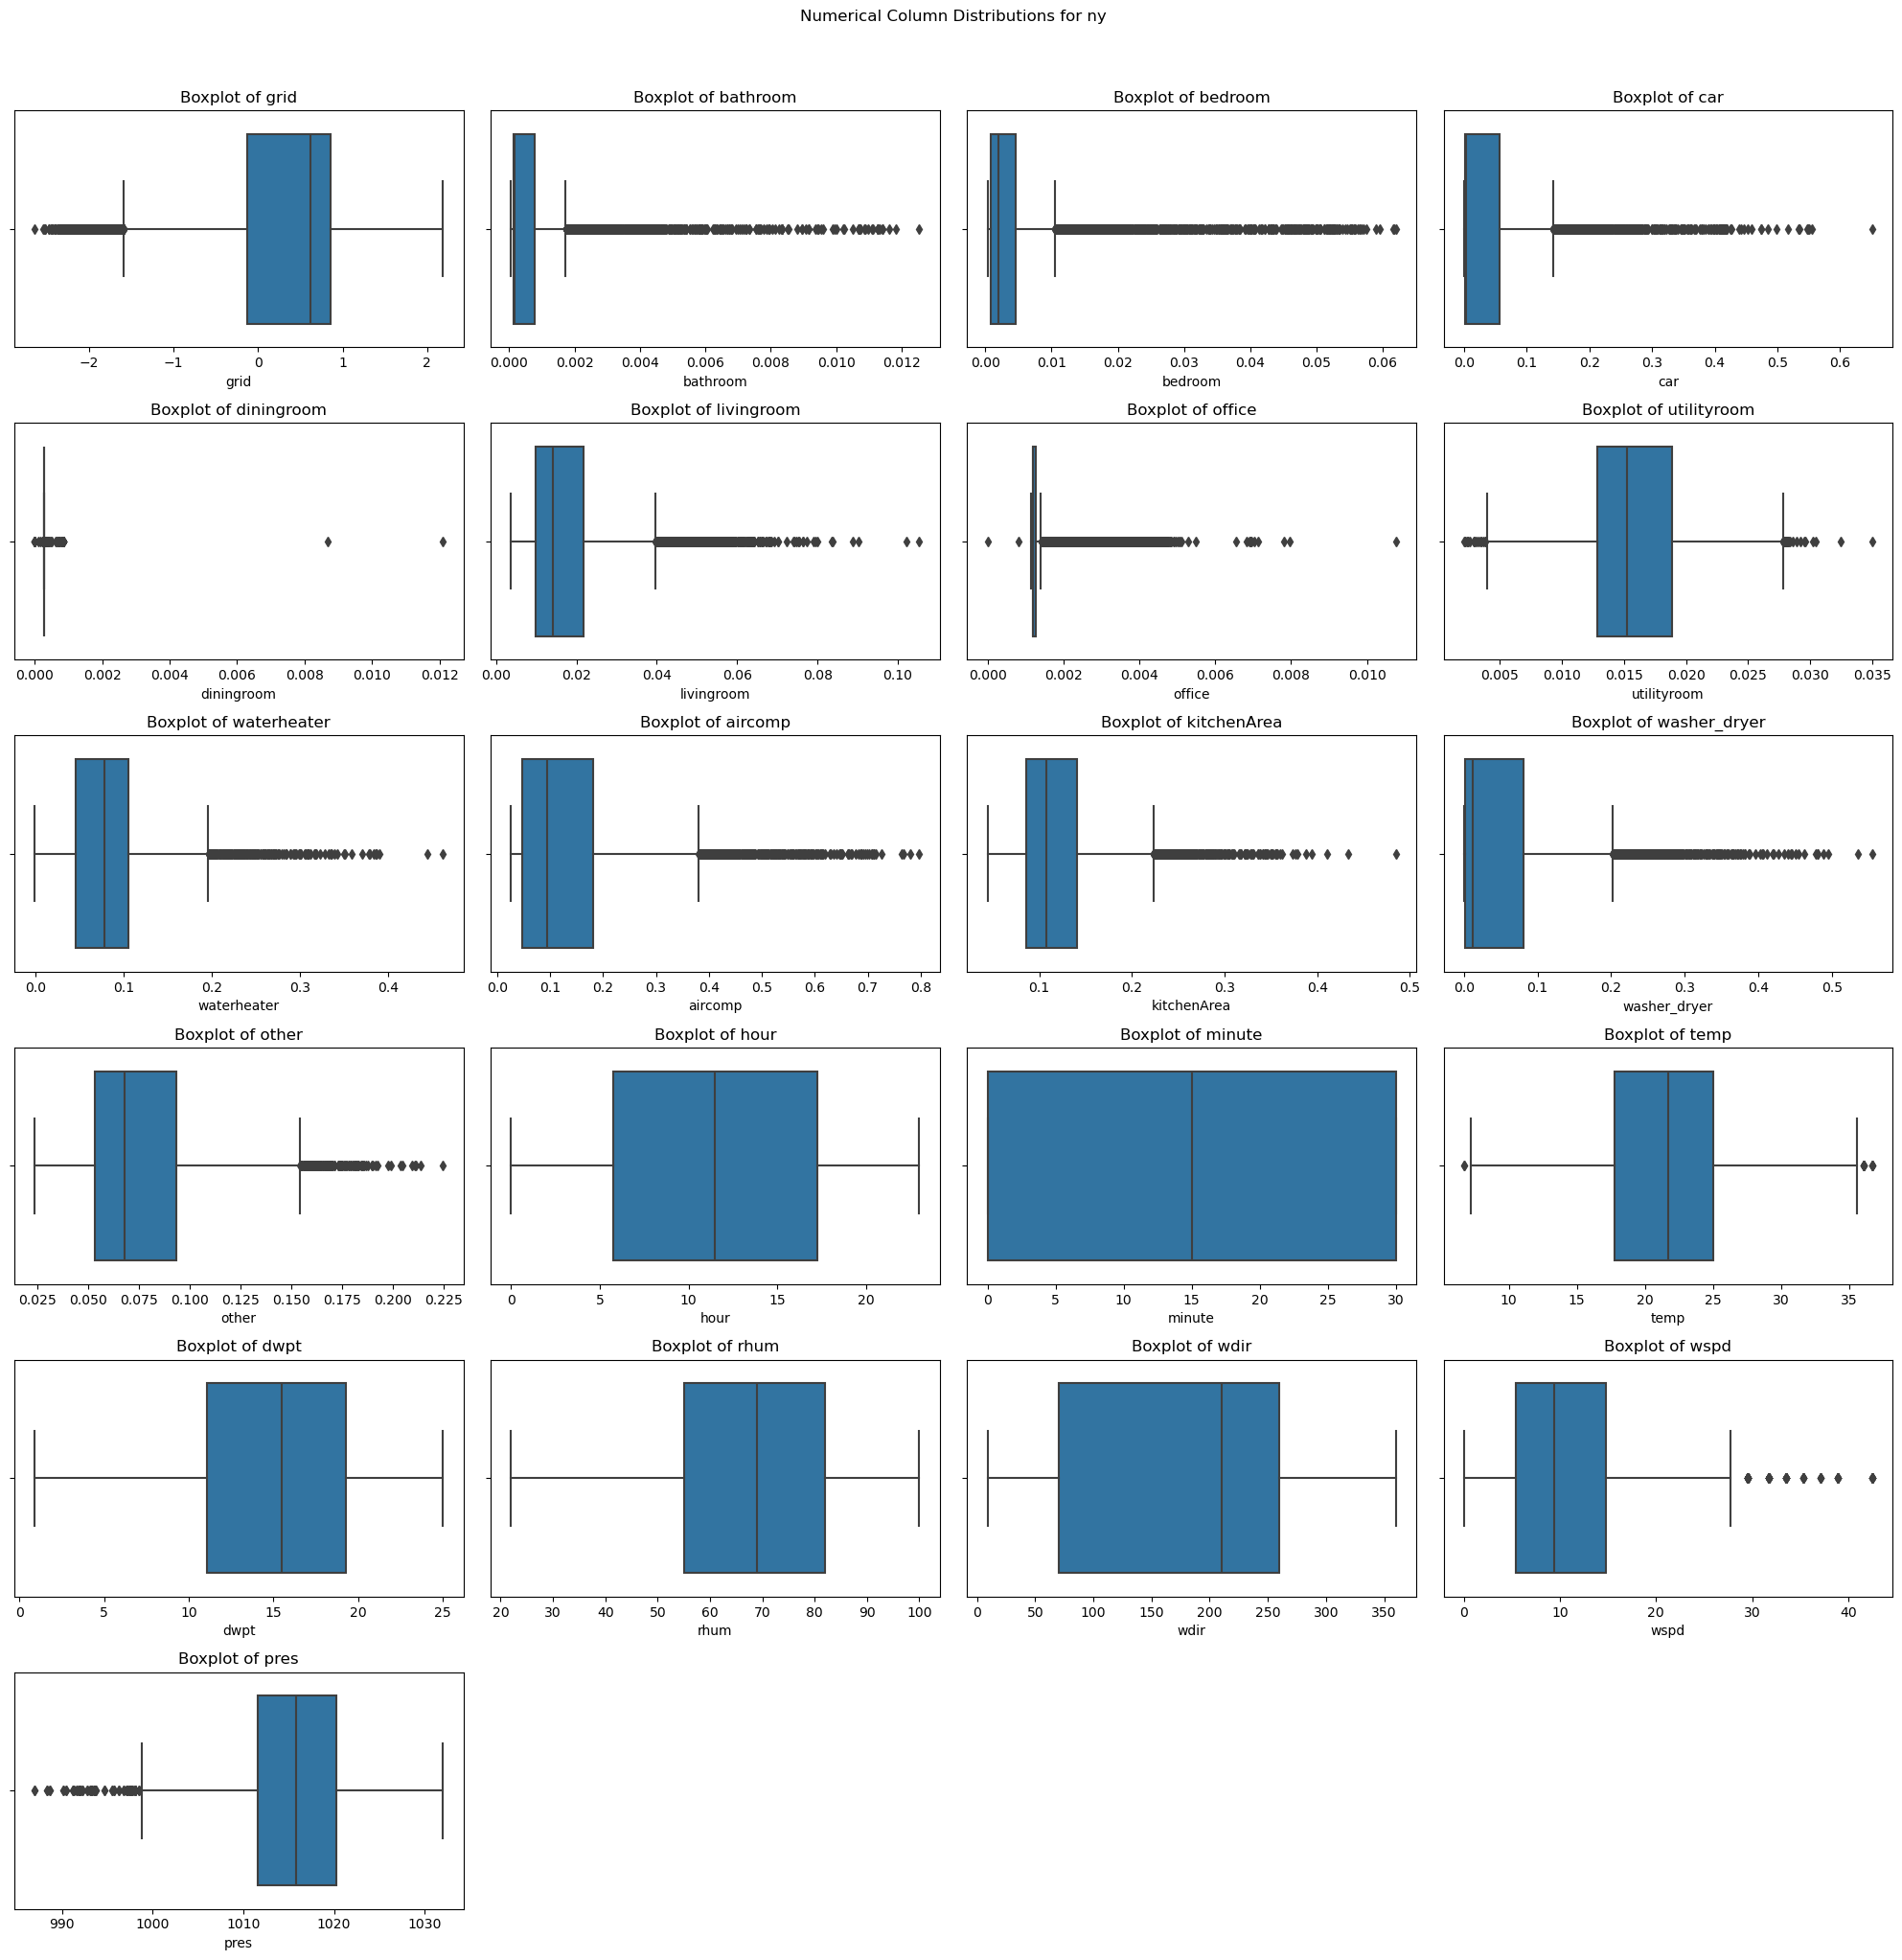

In [25]:
# Loop through each city and process the 'df_cleaned'
for city, city_data in data_dict.items():
    if 'df_cleaned' in city_data:
        df_cleaned = city_data['df_cleaned']
        
        # Select only numerical columns for visualization
        num_cols = df_cleaned.select_dtypes(include='number').columns
        
        # Set up the plot layout based on the number of numerical columns
        plt.figure(figsize=(20, 20))
        for i, column in enumerate(num_cols):
            plt.subplot((len(num_cols) // 4) + 1, 4, i + 1)  # Adjust rows and columns as needed
            sns.boxplot(x=df_cleaned[column])
            plt.title(f'Boxplot of {column}')

        # Show the plot for each city
        plt.suptitle(f'Numerical Column Distributions for {city}', y=1.02)
        plt.tight_layout()
        plt.show()

### Categorical

In [26]:
# Loop through each city and filter out months with fewer than 15 unique days
for city, city_data in data_dict.items():
    if 'df_cleaned' in city_data:
        df_cleaned = city_data['df_cleaned']
        
        # Find months with at least 15 unique days
        months_to_keep = df_cleaned.groupby('month')['day'].transform('nunique') >= 15
        
        # Filter df_cleaned based on months_to_keep and update in data_dict
        city_data['df_cleaned'] = df_cleaned[months_to_keep].reset_index(drop=True)

        print(f"After filtering, '{city}' has months with sufficient data.")

After filtering, 'austin' has months with sufficient data.
After filtering, 'ny' has months with sufficient data.


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13372/1511664576.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  months_to_keep = df_cleaned.groupby('month')['day'].transform('nunique') >= 15


/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


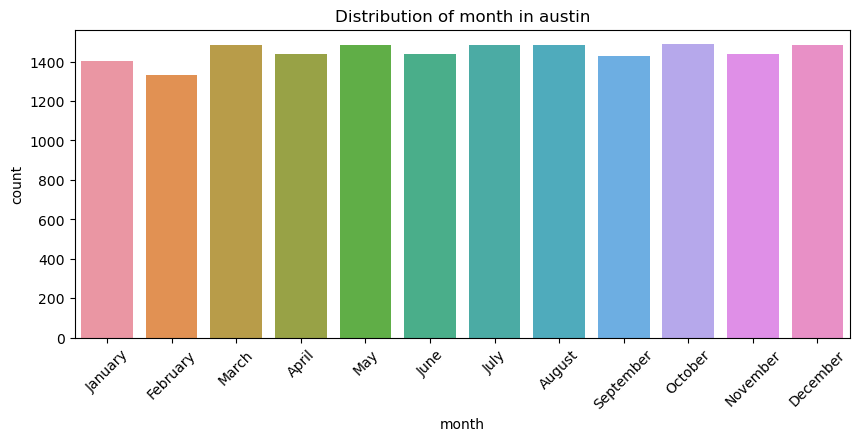

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


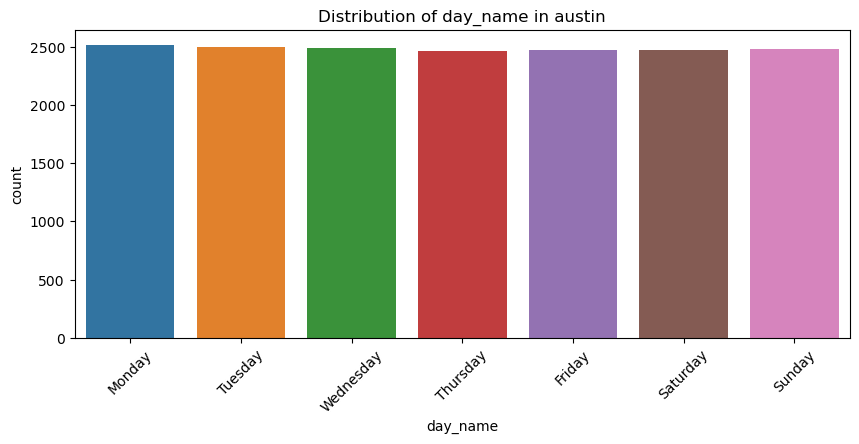

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


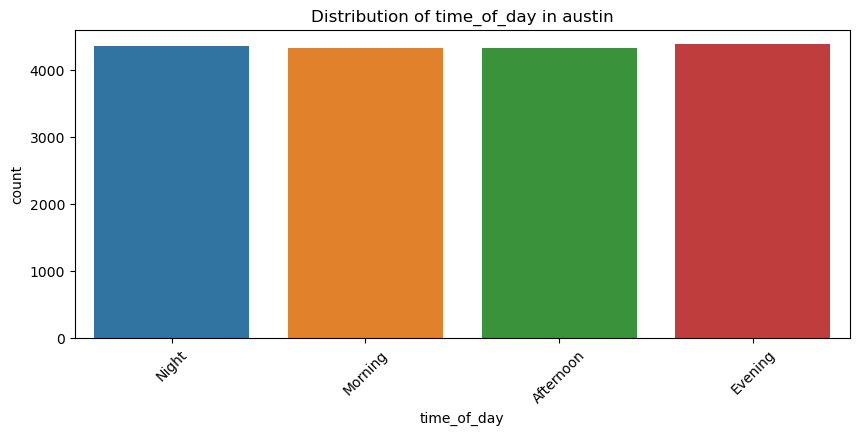

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


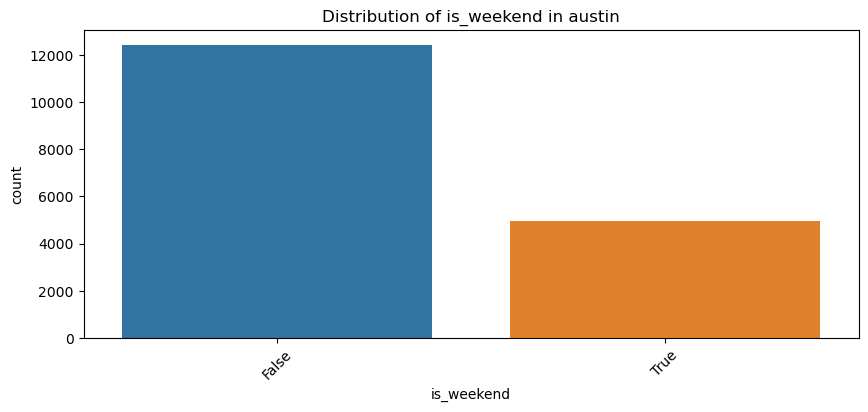

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


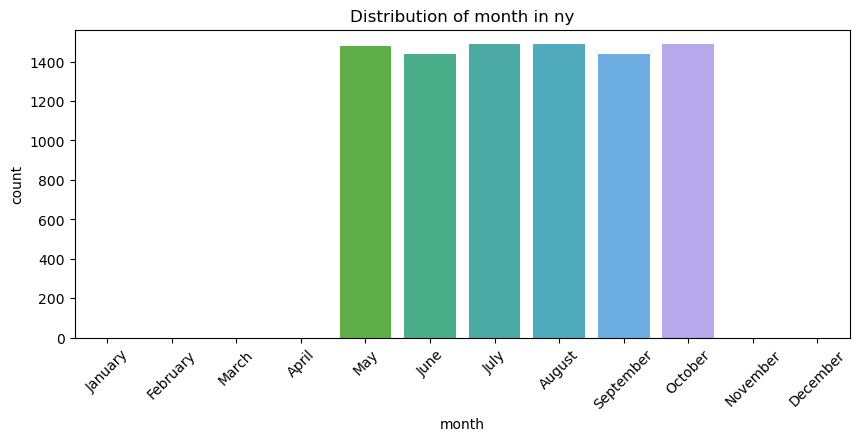

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


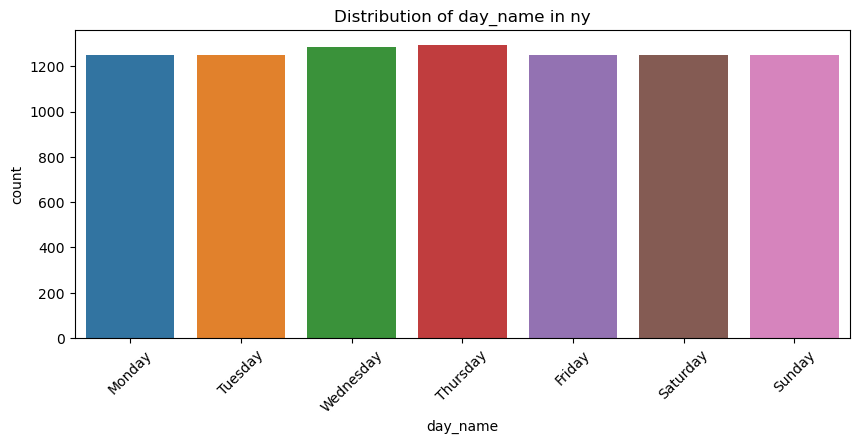

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


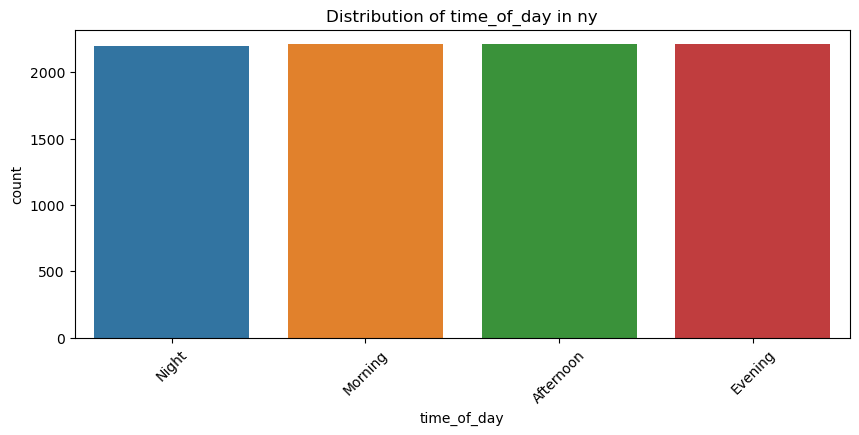

/Users/hassan/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


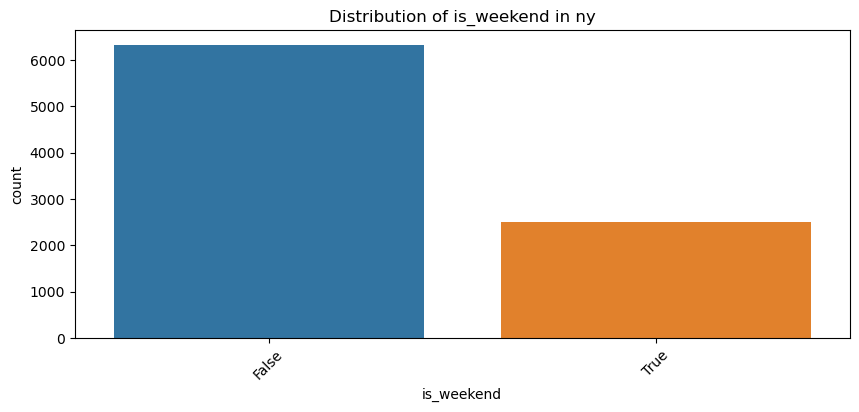

In [27]:
# Loop through each city and create bar charts for each categorical variable in df_cleaned
for city, city_data in data_dict.items():
    if 'df_cleaned' in city_data:
        df_cleaned = city_data['df_cleaned']
        
        # Identify categorical columns in df_cleaned
        categorical_columns = df_cleaned.select_dtypes(include='category').columns.tolist()
        
        # Plot each categorical column
        for column in categorical_columns:
            plt.figure(figsize=(10, 4))
            sns.countplot(x=column, data=df_cleaned)
            plt.title(f'Distribution of {column} in {city}')
            plt.xticks(rotation=45)
            plt.show()

## Major Columns

In [28]:
data_dict['austin']['df_cleaned'].columns

Index(['date', 'grid', 'bathroom', 'bedroom', 'car', 'diningroom',
       'livingroom', 'office', 'utilityroom', 'waterheater', 'aircomp',
       'kitchenArea', 'washer_dryer', 'other', 'day', 'month', 'day_name',
       'hour', 'minute', 'time_of_day', 'is_weekend', 'temp', 'dwpt', 'rhum',
       'wdir', 'wspd', 'pres', 'season', 'is_holiday'],
      dtype='object')

In [29]:
# Define the output directory
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# List to store each city's DataFrame for later concatenation
combined_data = []

# Loop through each city, retain selected columns, add city name, and save individually
for city, city_data in data_dict.items():
    if 'df_cleaned' in city_data:
        # Keep only the specified columns in df_cleaned
        df_to_save = city_data['df_cleaned'].copy()

        # Add a 'city' column to the DataFrame
        df_to_save['city'] = city
        
        # Define the file path for the individual city CSV
        file_path = os.path.join(output_dir, f"{city}.csv")
        
        # Save the individual city DataFrame to CSV
        df_to_save.to_csv(file_path, index=False)
        print(f"Processed data for '{city}' saved to {file_path}")
        
        # Append the modified DataFrame to the list for combining
        combined_data.append(df_to_save)

# Concatenate all city DataFrames into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Save the combined DataFrame to CSV
combined_file_path = os.path.join(output_dir, "combined_data.csv")
combined_df.to_csv(combined_file_path, index=False)
print(f"Combined data for all cities saved to {combined_file_path}")

Processed data for 'austin' saved to ../data/processed/austin.csv
Processed data for 'ny' saved to ../data/processed/ny.csv
Combined data for all cities saved to ../data/processed/combined_data.csv
